# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
# pip install -r requirements.in --quiet
!pip install sunriset

In [ ]:
!pip3 install "bokeh==3.2.2"

### Load packages

In [11]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datacube
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup


### Set analysis parameters

In [4]:
# Set study area and config
study_area = "gulfcarpentaria1" #"pointstuart"
config_path = "configs/dea_intertidal_config_development.yaml"
# study_area = '844'
# config_path='configs/dea_intertidal_config.yaml'

# Intertidal Elevation variables
start_date = "2018"  # Start date for analysis
end_date = "2020"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = False  # Filter to remove poorly georeferenced scenes?
tide_model = "FES2014"  # Tide model to use in analysis
# tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
modelled_freq = "3h"  # Frequency to run tidal model e.g '30min' or '1h'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

#### *Optional: override study area selection using interactive map*

In [ ]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                       layers=(basemap,),
                       center=(-26, 135),
                       zoom=4)
study_area = geom

## Intertidal workflow

### Load data

In [5]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_workflow")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    s2_prod="s2_nbart_ndwi" if include_s2 else None,
    ls_prod="ls_nbart_ndwi" if include_ls else None,
    config_path=config_path,
    filter_gqa=filter_gqa)[["ndwi"]]

# Load data and close dask client
satellite_ds.load()
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46101,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:36761,Total threads: 62
Dashboard: /user/claire.phillips@ga.gov.au/proxy/33897/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:45041,


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [6]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [7]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    config_path=config_path,
)

2023-11-17 03:13:31 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Reprojecting tides into original array


2023-11-17 03:13:54 INFO Masking nodata and adding tide heights to satellite data array
2023-11-17 03:13:54 INFO Flattening satellite data array and filtering to intertidal candidate pixels
2023-11-17 03:13:54 INFO Applying valid data mask to constrain study area
2023-11-17 03:14:00 INFO Running per-pixel rolling median


Reducing analysed pixels from 265370 to 81333 (30.65%)


100%|██████████| 114/114 [01:43<00:00,  1.10it/s]
2023-11-17 03:15:47 INFO Modelling intertidal elevation
2023-11-17 03:15:47 INFO Modelling intertidal uncertainty
2023-11-17 03:15:48 INFO Unflattening data back to its original spatial dimensions
2023-11-17 03:15:48 INFO Successfully completed intertidal elevation modelling


### Intertidal extents


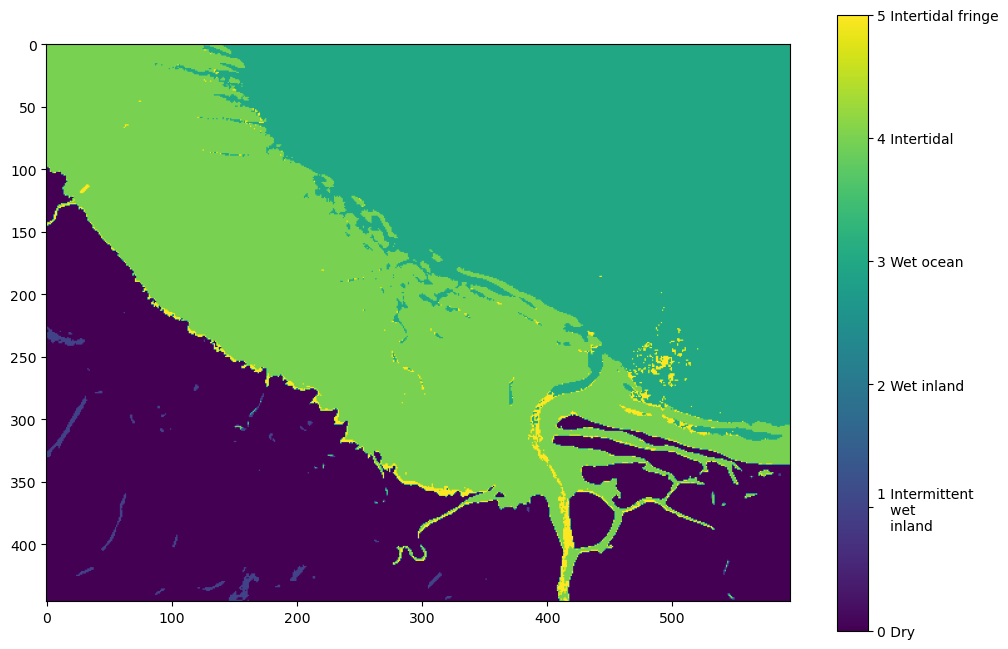

In [12]:
ds['extents'] = extents(ds_aux.ndwi_wet_freq, ds.elevation, ds_aux.ndwi_tide_corr)

## Plot
labels=['0 Dry',
       '1 Intermittent\n   wet\n   inland',
       '2 Wet inland',
       '3 Wet ocean',
       '4 Intertidal',
       '5 Intertidal fringe']

fig,ax=plt.subplots(figsize=(12,8))
cax=ax.imshow(ds['extents'])
cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
cbar.ax.set_yticklabels(labels)
plt.show()

### Intertidal exposure
Calculate exposure using the script function

In [ ]:
ds["exposure"], tide_cq = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
)

### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [ ]:
(ds['oa_lat'], 
 ds['oa_hat'], 
 ds['oa_lot'], 
 ds['oa_hot'], 
 ds['oa_spread'], 
 ds['oa_offset_lowtide'],
 ds['oa_offset_hightide']) = bias_offset(tide_m=tide_m,
                                      tide_cq=tide_cq,
                                      extents=ds.extents,
                                      lot_hot=True,
                                      lat_hat=True)

### Tideline confidence

In [ ]:
(hightideline, 
 lowtideline, 
 tidelines_gdf) = tidal_offset_tidelines(extents=ds.extents,
                                         offset_hightide=ds.oa_offset_hightide,
                                         offset_lowtide=ds.oa_offset_lowtide,
                                         distance=250)

## Plot all layers

In [ ]:
# Inspect contents of ds before plotting
ds

In [ ]:
fig = plt.figure(figsize=(16, 18), tight_layout=True)
ax_dict = fig.subplot_mosaic(
    """
    AAAABBBBCCCC
    DDDEEEFFFGGG
    HHHIIIJJJKKK
    LLLMMM......
    """,
    height_ratios=[1, 0.8, 0.8, 0.8],
)

# label_params = dict(add_labels=False, yticks=[], xticks=[])

# Plot Elevation with hillshade
ds["elevation"].plot.imshow(
    ax=ax_dict["A"],
    cmap="viridis",
    interpolation="bilinear",
)
intertidal_hillshade(ds["elevation"], ds["extents"], vert_exag=300).plot.imshow(
    ax=ax_dict["A"],
    interpolation="bilinear",
)
ax_dict["A"].set_title("Elevation (metres AMSL)")

# Plot uncertainty
ds["elevation_uncertainty"].plot.imshow(
    ax=ax_dict["B"],
    cmap="magma",
    interpolation="bilinear",
)
ax_dict["B"].set_title("Elevation uncertainty (metres)")
ax_dict["B"].set_facecolor("#2E2E2E")

# Plot Exposure
ds["exposure"].plot.imshow(
    ax=ax_dict["C"],
    cmap="RdYlGn",
    levels=np.arange(0, 100, 1),
    add_labels=False,
    yticks=[],
)
ax_dict["C"].set_title("Exposure")

# Plot the always/sometimes/never wet extents
ds["extents"].astype(np.int16).plot.imshow(ax=ax_dict["D"])
ax_dict["D"].set_title("Wet, Dry and Intertidal extent")

# Plot the observation spread
ds["oa_spread"].plot.imshow(
    ax=ax_dict["E"],
    vmin=0,
    vmax=100,
    cmap="magma",
    cbar_kwargs={"label": "% of tidal range observed"},
)
ax_dict["E"].set_title("Observation Spread (%)")

# Plot the high-tide offset
ds["oa_offset_hightide"].plot.imshow(
    ax=ax_dict["F"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of high tide never observed"},
)
ax_dict["F"].set_title("High-tide offset (%)")

# Plot the low-tide offset
ds["oa_offset_lowtide"].plot.imshow(
    ax=ax_dict["G"],
    vmin=0,
    vmax=40,
    cmap="magma",
    cbar_kwargs={"label": "% of low tide never observed"},
)
ax_dict["G"].set_title("Low-tide offset (%)")

# Plot the LAT
ds["oa_lat"].plot.imshow(
    ax=ax_dict["H"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
)
ax_dict["H"].set_title("Lowest Astronomical Tide")

# Plot the LOT
ds["oa_lot"].plot.imshow(
    ax=ax_dict["I"], vmin=ds["oa_lat"].min(), vmax=ds["oa_hat"].max()
)
ax_dict["I"].set_title("Lowest Observed Tide")

# Plot the HAT
ds["oa_hat"].plot.imshow(
    ax=ax_dict["J"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
    add_labels=False,
    yticks=[],
)
ax_dict["J"].set_title("Highest Astronomical Tide")

# Plot the HOT
ds["oa_hot"].plot.imshow(
    ax=ax_dict["K"],
    vmin=ds["oa_lat"].min(),
    vmax=ds["oa_hat"].max(),
)
ax_dict["K"].set_title("Highest Observed Tide")

# Plot the high and low tidelines with respective offset
ax_dict["L"].set_title("Lowtide line and lowtide offset")
lowtideline.plot(
    column="offset_lowtide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax_dict["L"],
    zorder=2,
)
tidelines_gdf.loc[[0], "geometry"].plot(ax=ax_dict["L"], zorder=1)
ax_dict["L"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["L"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax_dict["M"].set_title("Hightide line and hightide offset")
hightideline.plot(
    column="offset_hightide",
    legend=True,
    vmin=0,
    vmax=40,
    cmap="magma",
    ax=ax_dict["M"],
    zorder=2,
)
tidelines_gdf.loc[[1], "geometry"].plot(ax=ax_dict["M"], zorder=1)
ax_dict["M"].set_yticks([])
ax_dict["M"].set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax_dict["M"].set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

# Remove axis labels
for label, ax in ax_dict.items():
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel("")
    ax.set_xlabel("")

## Export layers

In [ ]:
# If a custom area was selected from the map, use "testing" for output files
if isinstance(study_area, Geometry):
    study_area = 'testing'
    
# Create output folder. If it doesn't exist, create it
output_dir = f"data/interim/{study_area}"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Export figure
fig.savefig(f"data/figures/{study_area}_{start_date}_{end_date}.png")

In [ ]:
# Save rasters as GeoTIFFs
export_intertidal_rasters(ds, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}")
export_intertidal_rasters(ds_aux, prefix=f"{output_dir}/{study_area}_{start_date}_{end_date}_debug")

In [ ]:
# Export vector files
hightideline.to_crs("EPSG:4326").to_file(f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_hightide.geojson")
lowtideline.to_crs("EPSG:4326").to_file(f"{output_dir}/{study_area}_{start_date}_{end_date}_offset_lowtide.geojson")
tidelines_gdf.to_crs("EPSG:4326").to_file(f"{output_dir}/{study_area}_{start_date}_{end_date}_tidelines_highlow.geojson")